In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# Read in full sparkify dataset
# event_data = "s3n://dsnd-sparkify/sparkify_event_data.json"
sparkify_data = 'medium-sparkify-event-data.json'
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids.

### Clean the NA value in userId and sessionId

In [4]:
df.count()

543705

In [5]:
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

543705

### Clean the empty userId

In [6]:
df = df.filter(df.userId!="")
df.count()

528005

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

 See different pages

In [7]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



 Let's see one user who did Cancellation Confirmation

In [8]:
df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates().show(10)

+------+
|userId|
+------+
|   296|
|100010|
|200002|
|    51|
|   124|
|200037|
|    54|
|   234|
|   154|
|   132|
+------+
only showing top 10 rows



In [9]:
# add time to see the time clear
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts))

In [10]:
df.select(["userId", "page", "time", "level", "song", "sessionId"]).where(df.userId == "296").sort("time").show(100)

+------+---------------+-------------------+-----+--------------------+---------+
|userId|           page|               time|level|                song|sessionId|
+------+---------------+-------------------+-----+--------------------+---------+
|   296|       NextSong|2018-10-02 10:55:51| free|Right Now (Radio ...|      463|
|   296|       NextSong|2018-10-02 10:59:28| free|      Freddie's Dead|      463|
|   296|       NextSong|2018-10-02 11:06:40| free|      Lonesome Loser|      463|
|   296|       NextSong|2018-10-03 08:56:43| free|            Elegante|      631|
|   296|       NextSong|2018-10-03 09:00:42| free|              Winner|      631|
|   296|       NextSong|2018-10-03 09:04:46| free|        Last Of Days|      631|
|   296|       NextSong|2018-10-03 09:08:58| free|               Angel|      631|
|   296|       NextSong|2018-10-03 09:13:28| free|         L'Excessive|      631|
|   296|       NextSong|2018-10-03 09:16:31| free|     Baby I'm A Fool|      631|
|   296|       N

Add churn column

In [11]:
churn_users = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df_withchurn = df.withColumn("churn", df.userId.isin(churn_users_list))

Show the gender distribution between churn user and normal user

In [12]:
df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|  196|
|false|     F|  153|
| true|     F|   45|
| true|     M|   54|
+-----+------+-----+



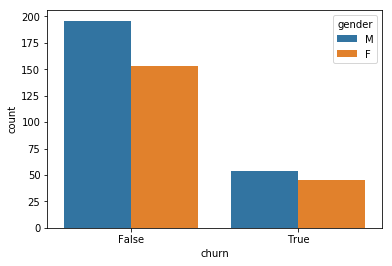

In [13]:
df_pd = df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_pd)

Show the page use distribution between churn user and normal user

In [14]:
churn_count = df_withchurn.filter(df_withchurn.churn==1).count()
no_churn_count = df_withchurn.filter(df_withchurn.churn==0).count()

df_temp1 = df_withchurn.filter(df_withchurn.churn==1).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("cFreq", df_temp1["count"]/(churn_count/100)).sort("page")

df_temp2 = df_withchurn.filter(df_withchurn.churn==0).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("ncFreq", df_temp2["count"]/(no_churn_count/100)).sort("page")

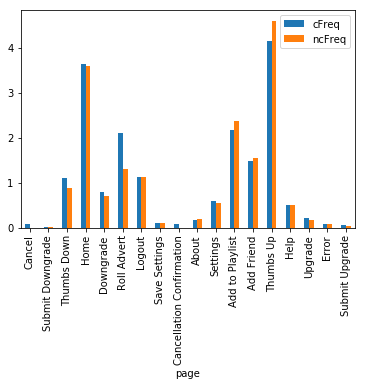

In [15]:
df_pd = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
df_pd.plot.bar("page")

Show the level when the user churned

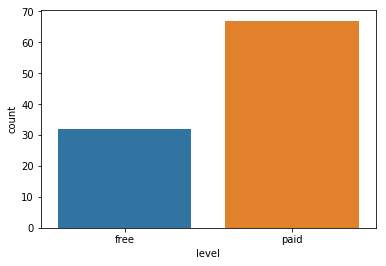

In [16]:
df_pd = df_withchurn.filter(df_withchurn.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_pd)

Show the time span of the log

In [17]:
df_withchurn.select("time").describe().show()

+-------+-------------------+
|summary|               time|
+-------+-------------------+
|  count|             528005|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 00:00:11|
|    max|2018-12-01 00:01:06|
+-------+-------------------+



Show the distribution in operations in each session

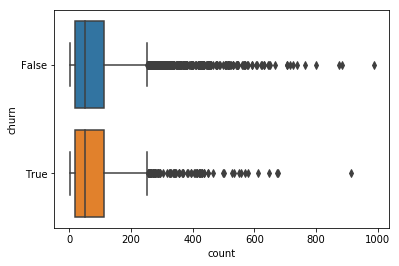

In [18]:
df_pd = df_withchurn.groupby("churn", "userId", "sessionId").count().toPandas()
sns.boxplot(x='count', y='churn', orient="h", data=df_pd)

Time distribution

In [19]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_withchurn = df_withchurn.withColumn("hour", get_hour(df_withchurn.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df_withchurn = df_withchurn.withColumn("weekday", get_weekday(df_withchurn.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df_withchurn = df_withchurn.withColumn("day", get_day(df_withchurn.ts))

In [20]:
def plot_cnt_by_churn(time): 
    """
    This function use to plot the distribution of different dimension
    """
    df_pd = df_withchurn.filter(df_withchurn.page == "NextSong").groupby("churn", time).count().orderBy(df_withchurn[time].cast("float")).toPandas()
    df_pd[time] = pd.to_numeric(df_pd[time])
    df_pd[df_pd.churn==0].plot.bar(x=time, y='count', color='Blue', label='Not churn')
    df_pd[df_pd.churn==1].plot.bar(x=time, y='count', color='Red', label='Churn')

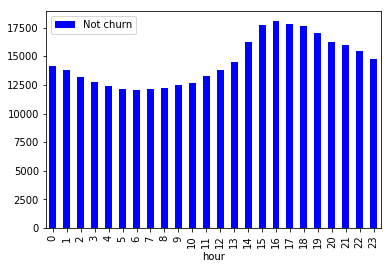

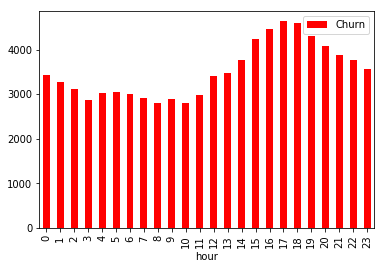

In [21]:
plot_cnt_by_churn("hour")

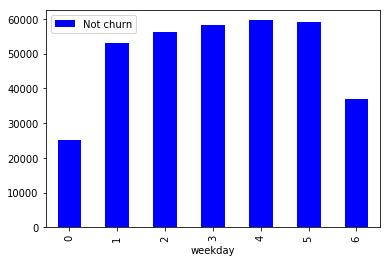

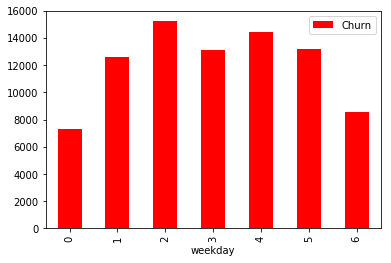

In [22]:
plot_cnt_by_churn("weekday")

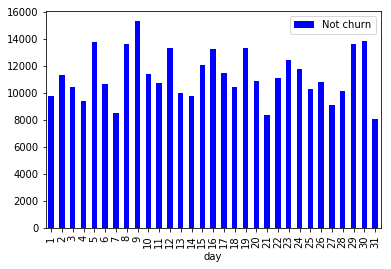

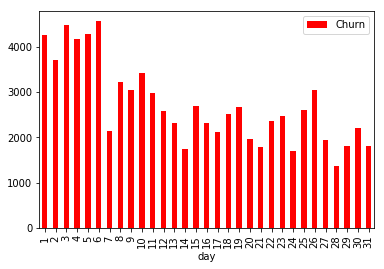

In [23]:
plot_cnt_by_churn("day")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Feature 1: number of days since registration

In [24]:
user_max_ts = df_withchurn.groupby("userId").max("ts").sort("userId")
user_reg_ts = df_withchurn.select("userId", "registration").dropDuplicates().sort("userId")
user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))

In [25]:
user_reg_days.show(5)

+------+------------------+
|userId|            regDay|
+------+------------------+
|100010|14.328449074074074|
|200002| 53.32314814814815|
|   296| 26.63826388888889|
|   125|105.42211805555556|
|   124| 112.5537962962963|
+------+------------------+
only showing top 5 rows



Feature 2: avg & min & max time per session

In [26]:
user_session_time = df_withchurn.groupby("userId", "sessionId").agg(((max(df_withchurn.ts)-min(df_withchurn.ts))/(1000*60)).alias("sessionTime"))
user_session_time_stat = user_session_time.groupby("userId").agg(avg(user_session_time.sessionTime).alias("avgSessionTime"), min(user_session_time.sessionTime).alias("minSessionTime"), max(user_session_time.sessionTime).alias("maxSessionTime")).sort("userId")

In [27]:
user_session_time_stat.show(5)

+------+------------------+--------------------+------------------+
|userId|    avgSessionTime|      minSessionTime|    maxSessionTime|
+------+------------------+--------------------+------------------+
|    10|            1502.4|              1502.4|            1502.4|
|   100|350.47777777777776|0.016666666666666666|1645.2333333333333|
|100001|137.66111111111113|   42.13333333333333|202.13333333333333|
|100002|          150.2625|   52.63333333333333|333.43333333333334|
|100003|296.92777777777775|                 0.0|1277.2333333333333|
+------+------------------+--------------------+------------------+
only showing top 5 rows



Feature 3: number of songs per session

In [28]:
user_session_songs = df_withchurn.filter(df_withchurn.page=="NextSong").groupby("userId", "sessionId").count()
user_session_songs_avg = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avgSessionSongs")).sort("userId")

In [29]:
user_session_songs_avg.show(5)

+------+-----------------+
|userId|  avgSessionSongs|
+------+-----------------+
|    10|            360.0|
|   100|86.71794871794872|
|100001|             32.0|
|100002|            34.25|
|100003|           82.625|
+------+-----------------+
only showing top 5 rows



Feature 4: number of sessions

In [30]:
user_session_count = df_withchurn.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
user_session_count = user_session_count.withColumnRenamed("count", "sessionCount")

In [31]:
user_session_count.show(5)

+------+------------+
|userId|sessionCount|
+------+------------+
|200002|           5|
|   296|           5|
|100010|           2|
|   125|           3|
|     7|          15|
+------+------------+
only showing top 5 rows



Feature 5: gender

In [32]:
user_gender = df_withchurn.select("userId", "gender").dropDuplicates()
user_gender = user_gender.replace(["M", "F"], ["0", "1"], "gender")
user_gender = user_gender.select("userId", user_gender.gender.cast("int"))

In [33]:
user_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|   234|     0|
|   188|     1|
|    44|     1|
|   273|     0|
|    46|     1|
+------+------+
only showing top 5 rows



Feature 6: whether the user is currently a paid user

In [34]:
user_paid = df_withchurn.groupby("userId", "level").agg(max(df_withchurn.ts).alias("finalTime")).sort("userId")
user_recent_level_time = user_paid.groupby("userId").agg(max(user_paid.finalTime).alias("recent"))
user_recent_level = user_recent_level_time.join(user_paid, [user_paid.userId == user_recent_level_time.userId, user_recent_level_time.recent == user_paid.finalTime]).select(user_paid.userId, "level").sort("userId")
user_recent_level = user_recent_level.replace(["free", "paid"], ["0", "1"], "level")
user_recent_level = user_recent_level.select("userId", user_recent_level.level.cast("int"))

In [35]:
user_recent_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    0|
|100003|    1|
+------+-----+
only showing top 5 rows



Feature 7: frequency of use of pages

In [36]:
# get all the type of page
page_list = [(row['page']) for row in df_withchurn.select("page").dropDuplicates().collect()]

# must remove the column which will cause data leakage
page_list.remove("Cancel")
page_list.remove("Cancellation Confirmation")

# caculate the total page each user view
user_page_view_count = df_withchurn.groupby("userId").count()
user_page_view_count = user_page_view_count.withColumnRenamed("count", "pageCount")


for page in page_list:
    col_name = "count" + page.replace(" ", "")
    view_count = df_withchurn.filter(df_withchurn.page==page).groupby("userId").count()
    view_count = view_count.withColumnRenamed("count", col_name).withColumnRenamed("userId", "userIdTemp")
    user_page_view_count = user_page_view_count.join(view_count, user_page_view_count.userId==view_count.userIdTemp, "left").drop("userIdTemp")
user_page_view_count = user_page_view_count.sort("userId")
user_page_view_count = user_page_view_count.fillna(0)

In [37]:
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("pageCount")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageCount/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_count.createOrReplaceTempView("user_page_view_count")
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("pageCount")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageCount/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_freq = spark.sql(freq_sql)

In [38]:
user_page_view_freq.show(5)

+------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-------------------+-------------------+
|userId|freqSubmitDowngrade|     freqThumbsDown|          freqHome|      freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|       freqSettings| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|      freqThumbsUp|           freqHelp|        freqUpgrade|          freqError|  freqSubmitUpgrade|
+------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+-------------------+-------------------+---------------

Feature 8: how many singers have the user heard

In [39]:
user_artist_count = df_withchurn.filter(df_withchurn.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
user_artist_count = user_artist_count.withColumnRenamed("count", "aritstCount")

In [40]:
user_artist_count.show(5)

+------+-----------+
|userId|aritstCount|
+------+-----------+
|200002|        287|
|100010|         94|
|   296|        108|
|   125|         61|
|   124|       1240|
+------+-----------+
only showing top 5 rows



Label: churn

In [41]:
user_churn = df_withchurn.select("userId", "churn").dropDuplicates()
user_churn = user_churn.select("userId", user_churn.churn.cast("int"))

In [42]:
user_churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    73|    0|
|    19|    0|
|   209|    0|
|100005|    1|
|100030|    1|
+------+-----+
only showing top 5 rows



Put all the features into a dataframe

In [43]:
# put all the features dataframe into a list
features_list = []
features_list.append(user_reg_days)
features_list.append(user_session_time_stat)
features_list.append(user_session_songs_avg)
features_list.append(user_session_count)
features_list.append(user_gender)
features_list.append(user_recent_level)
features_list.append(user_page_view_freq)
features_list.append(user_artist_count)
features_list.append(user_churn)

In [44]:
# prepare the final dataframe to join all the other features
df_final = df_withchurn.select("userId").dropDuplicates()

In [45]:
def features_merge(df1, df2):
    """
    This function is used to merge the feature using left join
    input: two data frame to be merged
    output: merged dataframe
    """
    df2 = df2.withColumnRenamed("userId", "userIdTemp")
    df = df1.join(df2, df1.userId == df2.userIdTemp, "left").drop("userIdTemp")
    return df

In [46]:
# use function to merge the features in the list
for feature in features_list:
    df_final = features_merge(df_final, feature)

In [47]:
# sort and view the final dataframe
df_final = df_final.sort("userId")
df_final.persist()
df_final.show(5)

+------+------------------+------------------+--------------------+------------------+-----------------+------------+------+-----+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-------------------+-------------------+-----------+-----+
|userId|            regDay|    avgSessionTime|      minSessionTime|    maxSessionTime|  avgSessionSongs|sessionCount|gender|level|freqSubmitDowngrade|     freqThumbsDown|          freqHome|      freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|       freqSettings| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|      freqThumbsUp|           freqHelp|        freqUpgrade|          freqError|  freqSubmitUpgrade|aritstCount|churn|
+------+------------------+---------

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

See how many data do we have.

In [48]:
df_final.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   99|
|    0|  349|
+-----+-----+



In [3]:
out_path = "final_data.csv"

In [51]:
df_final.write.save(out_path, format="csv", header=True)

In [4]:
df_final = spark.read.csv(out_path, header=True)
df_final.persist()

DataFrame[userId: string, regDay: string, avgSessionTime: string, minSessionTime: string, maxSessionTime: string, avgSessionSongs: string, sessionCount: string, gender: string, level: string, freqSubmitDowngrade: string, freqThumbsDown: string, freqHome: string, freqDowngrade: string, freqRollAdvert: string, freqLogout: string, freqSaveSettings: string, freqAbout: string, freqSettings: string, freqAddtoPlaylist: string, freqAddFriend: string, freqNextSong: string, freqThumbsUp: string, freqHelp: string, freqUpgrade: string, freqError: string, freqSubmitUpgrade: string, aritstCount: string, churn: string]

Convert all the features to numeric.

In [5]:
num_features_list = df_final.columns[1:]
for f in num_features_list:
    f_name = f + "Num"
    df_final = df_final.withColumn(f_name, df_final[f].cast("float"))
    df_final = df_final.drop(f)

Put the features to be trained into a vector

In [6]:
assembler = VectorAssembler(inputCols=df_final.columns[1:-1], outputCol="NumFeatures")
data = assembler.transform(df_final)

In [7]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [8]:
data = data.select(data.churnNum.alias("label"), data.ScaledNumFeatures.alias("features"))

In [9]:
train, validation = data.randomSplit([0.9, 0.1], seed=42)
train = train.cache()

In [10]:
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lr = crossval.fit(train)

In [57]:
cvModel_lr.save('cvModel_lr.model')

In [11]:
cvModel_lr.avgMetrics

[0.758073899263998,
 0.7497375806871707,
 0.7192001597561979,
 0.758073899263998,
 0.7293296973108794,
 0.7004447445148309,
 0.758073899263998,
 0.703614600825628,
 0.6844117345843954,
 0.758073899263998,
 0.6844117345843954,
 0.6789098670303118]

In [12]:
dt = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 3, 4, 5, 6, 7, 8]) \
    .build()

crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_dt = crossval_dt.fit(train)

In [58]:
cvModel_dt.save('cvModel_dt.model')

In [13]:
cvModel_dt.avgMetrics

[0.7565946570271784,
 0.7258049225510617,
 0.730297846321325,
 0.7443833923626915,
 0.7130946011474181,
 0.7068870274222387,
 0.6958715865541752,
 0.7574408787067335,
 0.7032239208818312,
 0.7210414516078021,
 0.709387596619812,
 0.7086955016217351,
 0.7094761942424289,
 0.7039114252562907]

In [14]:
gbt = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[3, 10, 20]) \
    .addGrid(gbt.maxDepth,[2, 4, 6, 8]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_gbt = crossval_gbt.fit(train)

In [59]:
cvModel_gbt.save('cvModel_gbt.model')

In [15]:
cvModel_gbt.avgMetrics

[0.7556589146377879,
 0.7235617693870003,
 0.7086955016217351,
 0.7020047693945548,
 0.7645747104773,
 0.7276358548001591,
 0.7123277203890657,
 0.6962532169275872,
 0.7617155495442464,
 0.7407300678678377,
 0.7213336406877692,
 0.6915378469042275]

Use undersampling to optimize the F1 score

In [16]:
stratified_train = train.sampleBy('label', fractions={0: 99/349, 1: 1.0}).cache()
stratified_train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   89|
|  0.0|   87|
+-----+-----+



In [35]:
lrs =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lrs.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lrs.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval_lrs = CrossValidator(estimator=lrs,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lrs = crossval_lrs.fit(stratified_train)
cvModel_lrs.avgMetrics

[0.6131447724224084,
 0.6732860606468921,
 0.6696185966538797,
 0.6131447724224084,
 0.6616244386316069,
 0.6631856465289562,
 0.6131447724224084,
 0.6579597221554122,
 0.6684085924161665,
 0.6131447724224084,
 0.6714741182984848,
 0.5967248547354702]

In [60]:
cvModel_lrs.save('cvModel_lrs.model')

In [40]:
dts = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dts.impurity,['entropy', 'gini']) \
    .addGrid(dts.maxDepth,[2, 3, 4, 5, 6, 7, 8]) \
    .build()
crossval_dts = CrossValidator(estimator=dts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_dts = crossval_dts.fit(stratified_train)
cvModel_dts.avgMetrics

[0.5790664857616097,
 0.560014129134512,
 0.5624879615737753,
 0.5564878803818784,
 0.5756087372544202,
 0.5965221752848144,
 0.5934853590515807,
 0.5951811838091631,
 0.625616767112007,
 0.632753359193532,
 0.644576270545735,
 0.6545159044638099,
 0.6468125787571353,
 0.6468125787571353]

In [61]:
cvModel_dts.save('cvModel_dts.model')

In [37]:
gbts = GBTClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(gbts.maxIter,[3, 10, 20]) \
    .addGrid(gbts.maxDepth,[2, 4, 6, 8]) \
    .build()
crossval_gbts = CrossValidator(estimator=gbts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_gbts = crossval_gbts.fit(stratified_train)
cvModel_gbts.avgMetrics

[0.6411000472859321,
 0.6537710973398548,
 0.654020411011221,
 0.6468125787571353,
 0.6147909774649721,
 0.64235515976641,
 0.654020411011221,
 0.6468125787571353,
 0.6226481773714728,
 0.6467265330548766,
 0.6469282124296607,
 0.6468125787571353]

In [62]:
cvModel_gbts.save('cvModel_gbts.model')

Use the validate data to evaluate the best model through F1 score.

In [53]:
results = cvModel_lr.transform(validation)

In [54]:
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

0.6
0.3
0.4


In [51]:
results = cvModel_lrs.transform(validation)

In [52]:
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

0.42105263157894735
0.8
0.5517241379310345


In [55]:
cvModel_lrs.bestModel.coefficients

DenseVector([-0.3309, 0.0733, 0.0879, 0.0051, 0.1531, -0.0413, 0.0551, 0.33, -0.047, 0.6621, -0.0263, 0.4479, 0.1244, -0.2142, -0.1489, -0.3724, -0.0263, -0.0841, 0.0727, -0.5653, -0.2821, 0.1021, 0.1177, -0.1501, 0.1545, -0.0993])

In [56]:
df_final.columns

['userId',
 'regDayNum',
 'avgSessionTimeNum',
 'minSessionTimeNum',
 'maxSessionTimeNum',
 'avgSessionSongsNum',
 'sessionCountNum',
 'genderNum',
 'levelNum',
 'freqSubmitDowngradeNum',
 'freqThumbsDownNum',
 'freqHomeNum',
 'freqDowngradeNum',
 'freqRollAdvertNum',
 'freqLogoutNum',
 'freqSaveSettingsNum',
 'freqAboutNum',
 'freqSettingsNum',
 'freqAddtoPlaylistNum',
 'freqAddFriendNum',
 'freqNextSongNum',
 'freqThumbsUpNum',
 'freqHelpNum',
 'freqUpgradeNum',
 'freqErrorNum',
 'freqSubmitUpgradeNum',
 'aritstCountNum',
 'churnNum']